In [303]:
# imports
import torch

import learning.utils
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [304]:
# preparation
episodes = 100
steps = 25
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

# Set seed for all randomness sources
seed = 0

# init environments
envs = {
    "one-agent": {"agent_amount": 1},
    "two-agents": {"agent_amount": 2},
    "two-agents-mixed": {"agent_amount": 2, "mixed": True},
    "two-agents-percentage": {
        "agent_amount": 2, 
        "percentage":True
    },
    "three-agents": {"agent_amount": 3}
}

# init data logging 
log_data = {}

Device: cpu



In [305]:
def load_environment(setting):
    env_id = "Empty-Grid-v0"
    if "mixed" in setting:
        env = learning.utils.make_env(
            env_id, setting["agent_amount"], seed=seed, mixed_motive=setting["mixed"])
    elif "percentage" in setting:
        env = learning.utils.make_env(
            env_id, setting["agent_amount"], seed=seed, percentage_reward=setting["percentage"])
    else:
        env = learning.utils.make_env(
            env_id, setting["agent_amount"], seed=seed)
    return env

def load_agents(agent_amount, env, model): 
    model_dir = learning.utils.get_short_model_dir(model)
    agents = []
    for agent in range(agent_amount):
        agents.append(learning.utils.Agent(agent, env.observation_space, 
            env.action_space, model_dir, device=device))
    return agents

In [306]:
for key, env_settings in envs.items():
    #load environments and their agents
    env = load_environment(env_settings)
    agents = load_agents(env_settings["agent_amount"], env, key)


    # prepare logging
    for agent in range(len(agents)):
        log_data[key+"-reward-"+str(agent)] = []
    log_data[key+"-reset-fields"] = []
    log_data[key+"-grid-solved"] = []
    

    # gather the plotting data
    for episode in range(episodes):
        reset_fields = 0
        obs = env.reset()
        for step in range(0,steps):
            joint_actions = []
            for agent_index, agent in enumerate(agents):
                action = agent.get_action(obs, agent_index)
                joint_actions.append(action)

            obs, reward, done, info = env.step(joint_actions)
            reset_fields += info["reset_fields"]
            
            if done or step == steps-1: 
                # save reward here since we work with sparse rewards
                for agent, agent_reward in enumerate(reward):
                    log_data[key+"-reward-"+str(agent)].append(agent_reward)
                    
                log_data[key+"-reset-fields"].append(reset_fields)
                if 1 in reward:
                    log_data[key+"-grid-solved"].append(1)
                else:
                    log_data[key+"-grid-solved"].append(0)
                    
                break

---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID FULLY COLORED! ----
---- GRID 

In [307]:
line_styles = ["-", "--", "-.", ":", ".", ",", "o", "v", "^", "<", ">"]
colors = ["b", "g", "r", "c", "m", "y"]

def plot_data(log_key, title):
    plt.figure(figsize=(20,10))
    counter = 0
    for key, env_settings in envs.items():
        color = colors[counter] if counter < len(colors) else colors[len(colors)%counter]   
        if log_key == "reward":
            # "mixed" distinguished between agents, so plot every agent
            if "mixed" in env_settings and env_settings["mixed"]:
                for agent in range(env_settings["agent_amount"]):
                    line_style = line_styles[agent] if agent < len(line_styles) else line_styles[len(line_styles)%agent]        
                    plt.plot(log_data[key+"-"+log_key+"-"+str(agent)], color+line_style, label = key+str(agent))
            else:
                line = color + line_styles[0]
                plt.plot(log_data[key+"-"+log_key+"-0"], line, label = key)
        else:
            plt.plot(log_data[key+"-"+log_key], color, label = key)
            
        counter += 1

    plt.ylabel(log_key)
    plt.xlabel('episode')
    plt.grid(True)
    plt.title(title)
    plt.legend()
    plt.show()

def plot_barchart(labels, values, ylabel, title):
    plt.figure(figsize=(20,10))
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, labels)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show

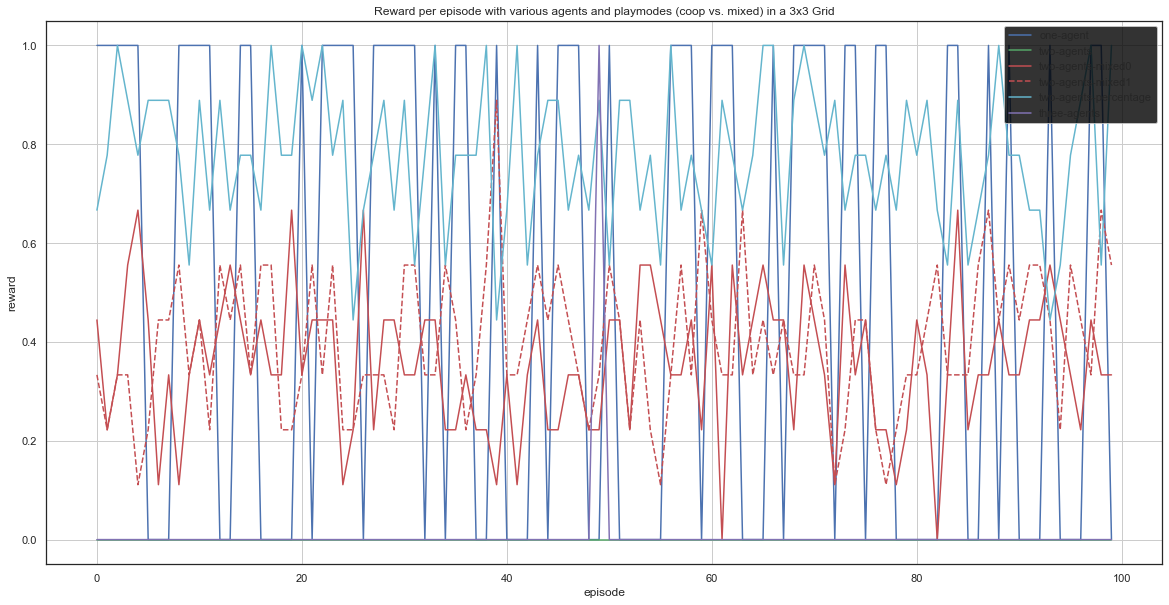

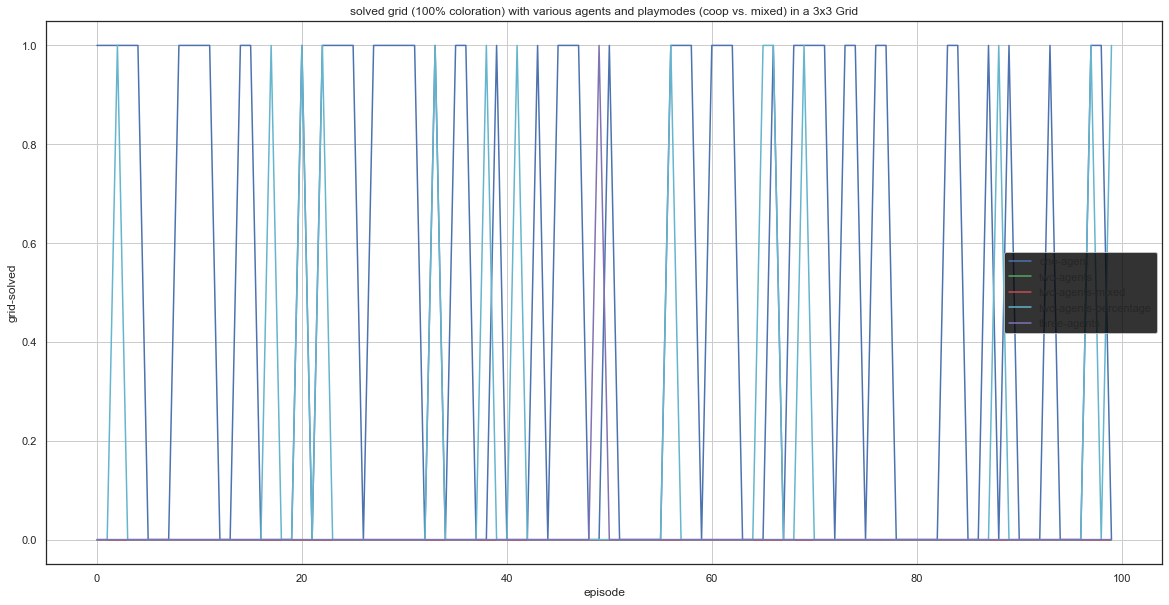

In [308]:
# plot the data

plot_data("reward", "Reward per episode with various agents and playmodes (coop vs. mixed) in a 3x3 Grid")
plot_data("grid-solved", "solved grid (100% coloration) with various agents and playmodes (coop vs. mixed) in a 3x3 Grid")
# plot_data("reset_fields", "Count of reset grid cells (colored to not colored) per episode with variing agent amount and playmode (coop vs. mixed) in a 3x3 Grid")

# bar_labels = tuple(envs)
# amount_solved_grid_per_setting = [sum(setting["grid_solved"]) for setting in log_data.values()]
# amount_reset_fields_per_setting = [sum(setting["reset_fields"]) for setting in log_data.values()]

# plot_barchart(bar_labels, amount_solved_grid_per_setting, "count of solved grid", 
#     "number of goal achievement (100% coloration) in each setting")

# plot_barchart(bar_labels, amount_reset_fields_per_setting, "count of reset fields", 
#     "number of reset fields (colored to not colored cell) in each setting")


In [336]:
# create dataframe
df = pd.DataFrame(log_data)

all_reward_cols = []
reward_cols = []
reset_fields_cols = []
grid_solved_cols = []
for col in df.columns:
    if "reward" in col:
        all_reward_cols.append(col)
        if "mixed" in col:
            reward_cols.append(col)
        elif "reward-0" in col:
            # in most cases rewards are the same for all agents so only safe one
            reward_cols.append(col)
    if "grid-solved" in col:
        grid_solved_cols.append(col)
    else:
        reset_fields_cols.append(col)


df_reward = df[reward_cols].transpose().stack().reset_index()
df_reward.rename(columns={0:'reward', "level_0": "setting", "level_1": "episode"}, inplace=True)

df_all = df.transpose().stack().reset_index()
print(df_all)

                       level_0  level_1    0
0           one-agent-reward-0        0  1.0
1           one-agent-reward-0        1  1.0
2           one-agent-reward-0        2  1.0
3           one-agent-reward-0        3  1.0
4           one-agent-reward-0        4  1.0
...                        ...      ...  ...
1995  three-agents-grid-solved       95  0.0
1996  three-agents-grid-solved       96  0.0
1997  three-agents-grid-solved       97  0.0
1998  three-agents-grid-solved       98  0.0
1999  three-agents-grid-solved       99  0.0

[2000 rows x 3 columns]


In [310]:
print(df_reward.loc[df_reward["setting"] == "three-agents-reward-0"])

                   setting  episode  reward
500  three-agents-reward-0        0     0.0
501  three-agents-reward-0        1     0.0
502  three-agents-reward-0        2     0.0
503  three-agents-reward-0        3     0.0
504  three-agents-reward-0        4     0.0
..                     ...      ...     ...
595  three-agents-reward-0       95     0.0
596  three-agents-reward-0       96     0.0
597  three-agents-reward-0       97     0.0
598  three-agents-reward-0       98     0.0
599  three-agents-reward-0       99     0.0

[100 rows x 3 columns]


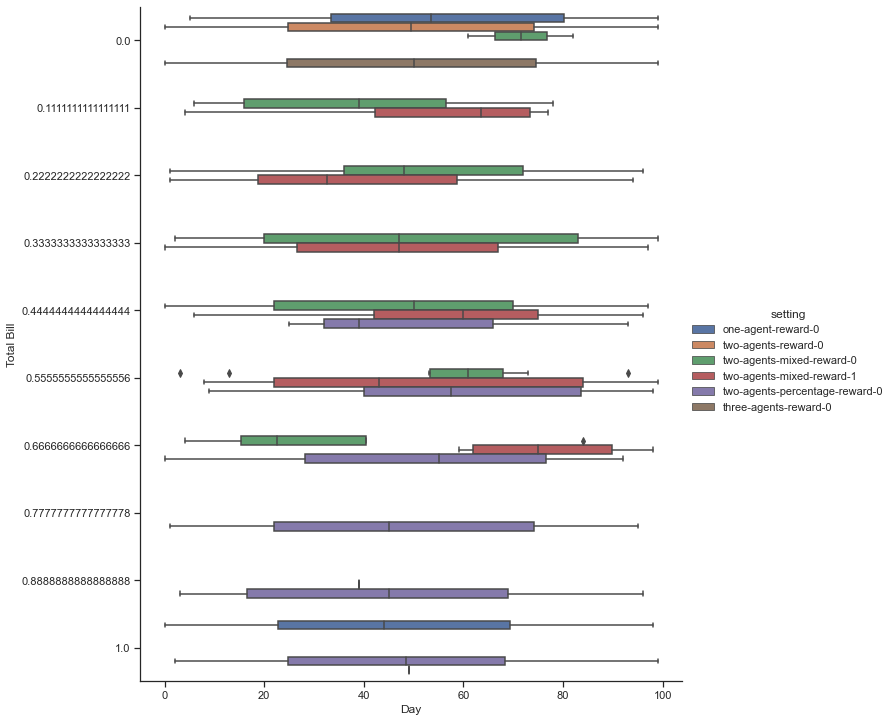

In [348]:
with sns.axes_style(style='ticks'):
    g = sns.catplot(y="reward", x="episode", hue="setting", orient="h", data=df_reward, kind="box", height=10)
    g.set_axis_labels("Episode", "Reward")

/Users/zarah/.local/share/virtualenvs/CMARL-CAP-and-Markets-IF-6R0HM/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/zarah/.local/share/virtualenvs/CMARL-CAP-and-Markets-IF-6R0HM/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


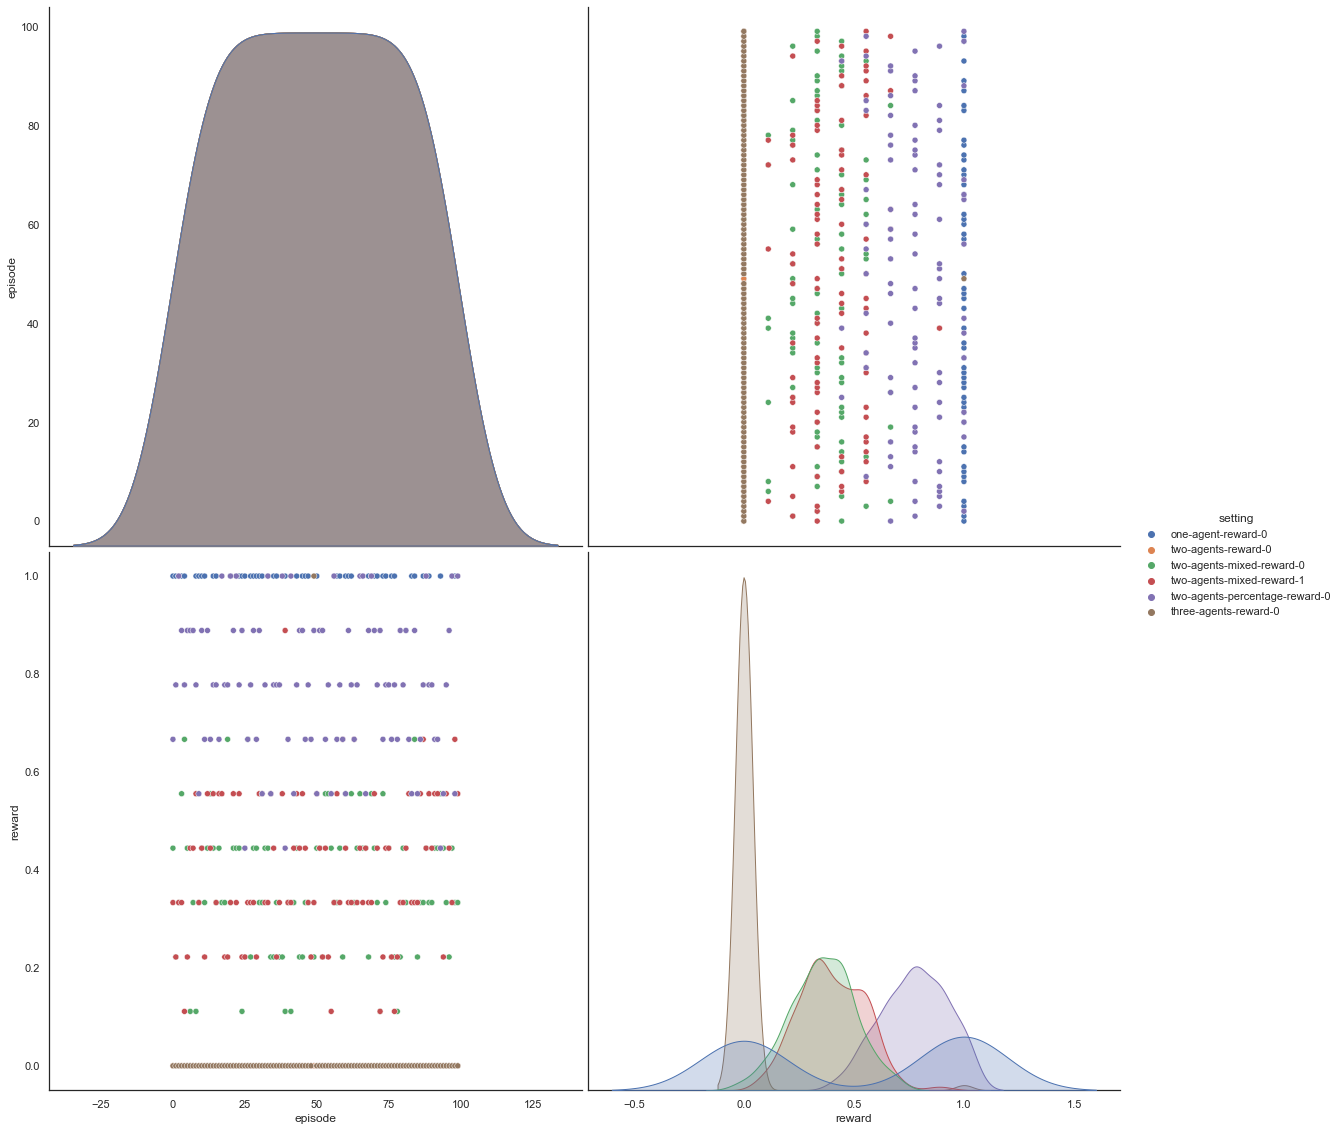

In [340]:
sns.pairplot(df_reward, hue='setting', size=8);

<AxesSubplot:>

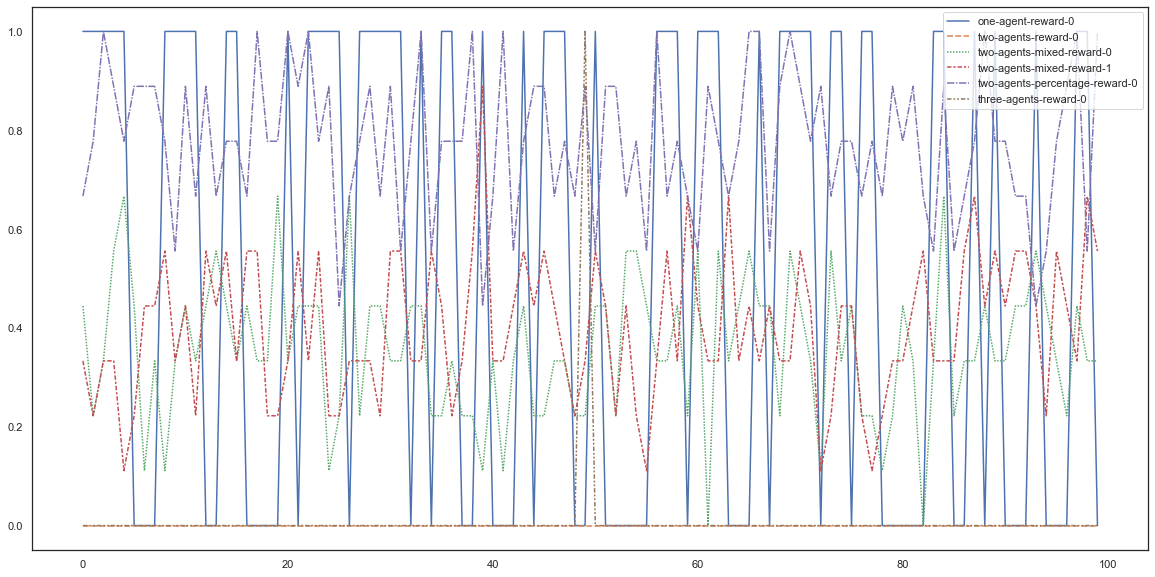

In [320]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=df[reward_cols], ax=ax)

/Users/zarah/.local/share/virtualenvs/CMARL-CAP-and-Markets-IF-6R0HM/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/zarah/.local/share/virtualenvs/CMARL-CAP-and-Markets-IF-6R0HM/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


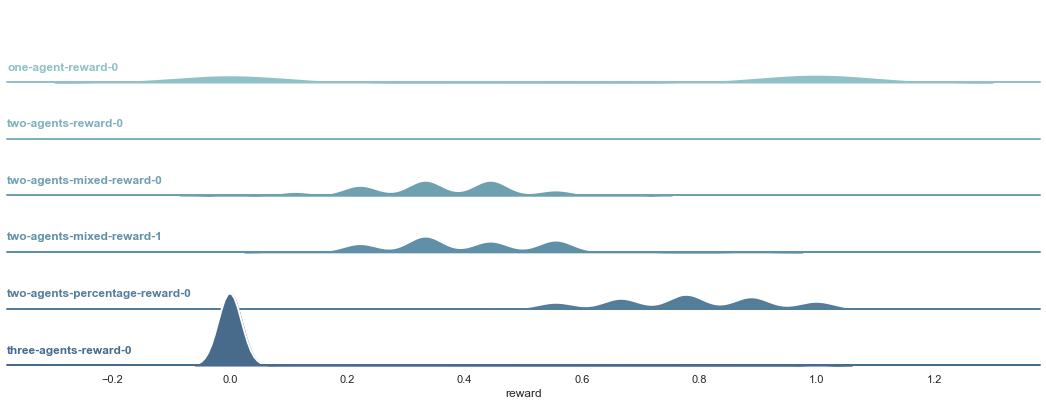

In [330]:
# seaborn plots
x = df_reward["reward"]

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# sns.lineplot(data=df[reward_cols].transpose(), ax=ax)

# sns.catplot(data=df[reward_cols], orient="h", kind="box", ax=ax)

# print(data)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_reward, row="setting", hue="setting", aspect=15, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "reward", 
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "reward", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "reward")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)